In [108]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import json
import os
import logging
import random
import itertools as it

In [75]:
x_data, y_data = fetch_openml('mnist_784', version=1, return_X_y=True)

In [80]:
def encode_int_onehot(int_to_encode, num_classes):
    vec = np.zeros(num_classes)
    vec[int_to_encode] = 1
    return vec

y_data = y_data.astype(np.int64)
y_one_hot = np.array([encode_int_onehot(y, np.max(y_data) + 1) for y in y_data.astype(np.int64)])

In [85]:
print(y_one_hot.shape)

(70000, 10)


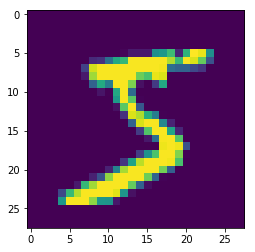

In [86]:
image_side_length = int(np.sqrt(len(x_data[0])))
for i in range(1):
    plt.imshow(x_data[i].reshape(image_side_length, image_side_length))
    plt.show()

In [184]:
def hinge_loss(pred, y_one_hot):
    correct_class = np.argmax(y_one_hot)
    value_correct_class = pred[correct_class]
    loss = np.maximum(0, pred - value_correct_class + 1)
    loss[correct_class] = 0
    return np.sum(loss)


class LinearClassifier():
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(output_size, input_size)

    def eval(self, inputs, overwrite_weights=None):
        active_weights = self.weights
        if overwrite_weights is not None:
            active_weights = overwrite_weights
        return np.matmul(active_weights, inputs)        

    def outputs_to_probabilities(self, outputs):
        squashed_result = outputs / np.amax(outputs)
        unnormal_probabilities = np.exp(squashed_result)
        if unnormal_probabilities[unnormal_probabilities == np.inf].any():
            raise Exception('There are infinity values in result after exponentiation. Weights might be initialized to high. Value is {}'
                            .format(unnormal_probabilities))
        probabilities = unnormal_probabilities / sum(unnormal_probabilities)
        return probabilities
    
    def batch_eval(self, inputs, overwrite_weights=None):
        return [self.eval(i, overwrite_weights=overwrite_weights) for i in inputs]

    def cost(self, output, one_hot_target, loss_func=hinge_loss):        
        return loss_func(output, one_hot_target)
    
    def cost_vrt(self, outputs, one_hot_targets, loss_func=hinge_loss):
        cost = 0
        for i, t in zip(outputs, one_hot_targets):
            cost += self.cost(i, t, loss_func=loss_func)
        return cost / len(outputs)
    
    def gradient_vrt(self, inputs, one_hot_targets, dx=0.01, batch_size=None):        
        data = zip(inputs, one_hot_targets)
        if batch_size:
            data = random.sample(list(data), batch_size)
        weight_mat_shape = self.weights.shape
        weight_mat_size = np.size(self.weights)
        total_gradient = np.zeros(weight_mat_shape)
        cnt = 0
        for sample_input, target in data:
            sample_gradient = []            
            #print("\033[F")
            print('{} / {}'.format(cnt, len(inputs)))
            cnt += 1
            for i in range(weight_mat_size):
                if i % 100 == 0:
                    print('{} / {}'.format(i, weight_mat_size), end='\r')
                nudge_weight_mat = np.zeros(weight_mat_size)
                nudge_weight_mat[i] = dx                
                nudge_weight_mat = nudge_weight_mat.reshape(weight_mat_shape)  
                nudged_weight_mat = self.weights + nudge_weight_mat                
                nudged_out = self.eval(sample_input, overwrite_weights=nudged_weight_mat)
                out = self.eval(sample_input)
                
                sample_gradient.append(self.cost(nudged_out, one_hot_targets) - self.cost(out, one_hot_targets))
                # print('n_out', nudged_out)
                # print('out', out)
                # print('diff', self.cost(nudged_out, one_hot_targets) - self.cost(out, one_hot_targets))
                # #print('diff weights', sum(nudged_weight_mat), sum(self.weights))
                # raise Exception()
            total_gradient += np.reshape(sample_gradient, weight_mat_shape)
        #print('pre noraml total grad', total_gradient)
        return total_gradient / np.size(data)
        
    def train(self, inputs, one_hot_targets, epochs=1, learning_rate=0.01, verbose=False, batch_size=None):
        prev_loss = None
        for ep in range(epochs):
            gradient = self.gradient_vrt(inputs, one_hot_targets, batch_size=batch_size)            
            self.weights = self.weights - gradient * learning_rate
            if verbose:
                #print('gradient:', gradient)
                print('gradient max val:', np.max(gradient))
                current_loss = self.cost_vrt(self.batch_eval(inputs), one_hot_targets)
                print('loss:', current_loss)
                if prev_loss:
                    print('loss improvment:', prev_loss - current_loss)
                prev_loss = current_loss
                print('----------')

In [196]:
lc = LinearClassifier(x_data[0].size, y_one_hot[0].size)

In [197]:
def run():    
    lc.train(x_data[:1], y_one_hot[:1], verbose=True, batch_size=None, epochs=3, learning_rate=0.01)
    r = lc.eval(x_data[0])
    
    print(np.argmax(r))
    print(np.argmax(y_one_hot[0]))
    
    idx_val = 100
    val_res = []
    for x, y in zip(x_data[:idx_val], y_one_hot[:idx_val]):
        val_res.append(np.argmax(lc.eval(x)) == np.argmax(y))
    correct_classified = int(sum(val_res) / len(val_res) * 100)
    print('{}% Classified correctly'.format(correct_classified))
    

run()



0 / 1


4300 / 7840

gradient max val: 0.0


loss: 0.0
----------
0 / 1
1900 / 7840

gradient max val:

 0.0
loss: 0.0
----------
0 / 1
1800 / 7840

gradient max val: 0.0
loss: 0.0
----------
5
5
4% Classified correctly


In [195]:
print('')

In [62]:
a = np.array([[1,2,0]])
b = np.array([-0,2,1])
print(a.shape)
print(b.shape)
np.matmul(a, b)

(1, 3)
(3,)
